# Part 3: Object identification and Tracking using RPi camera V2
## Srikumar Muralidharan <br>

Question 1: <br>
Step 1: Record image of self holding traffic signal image using raspberry pi. <br>
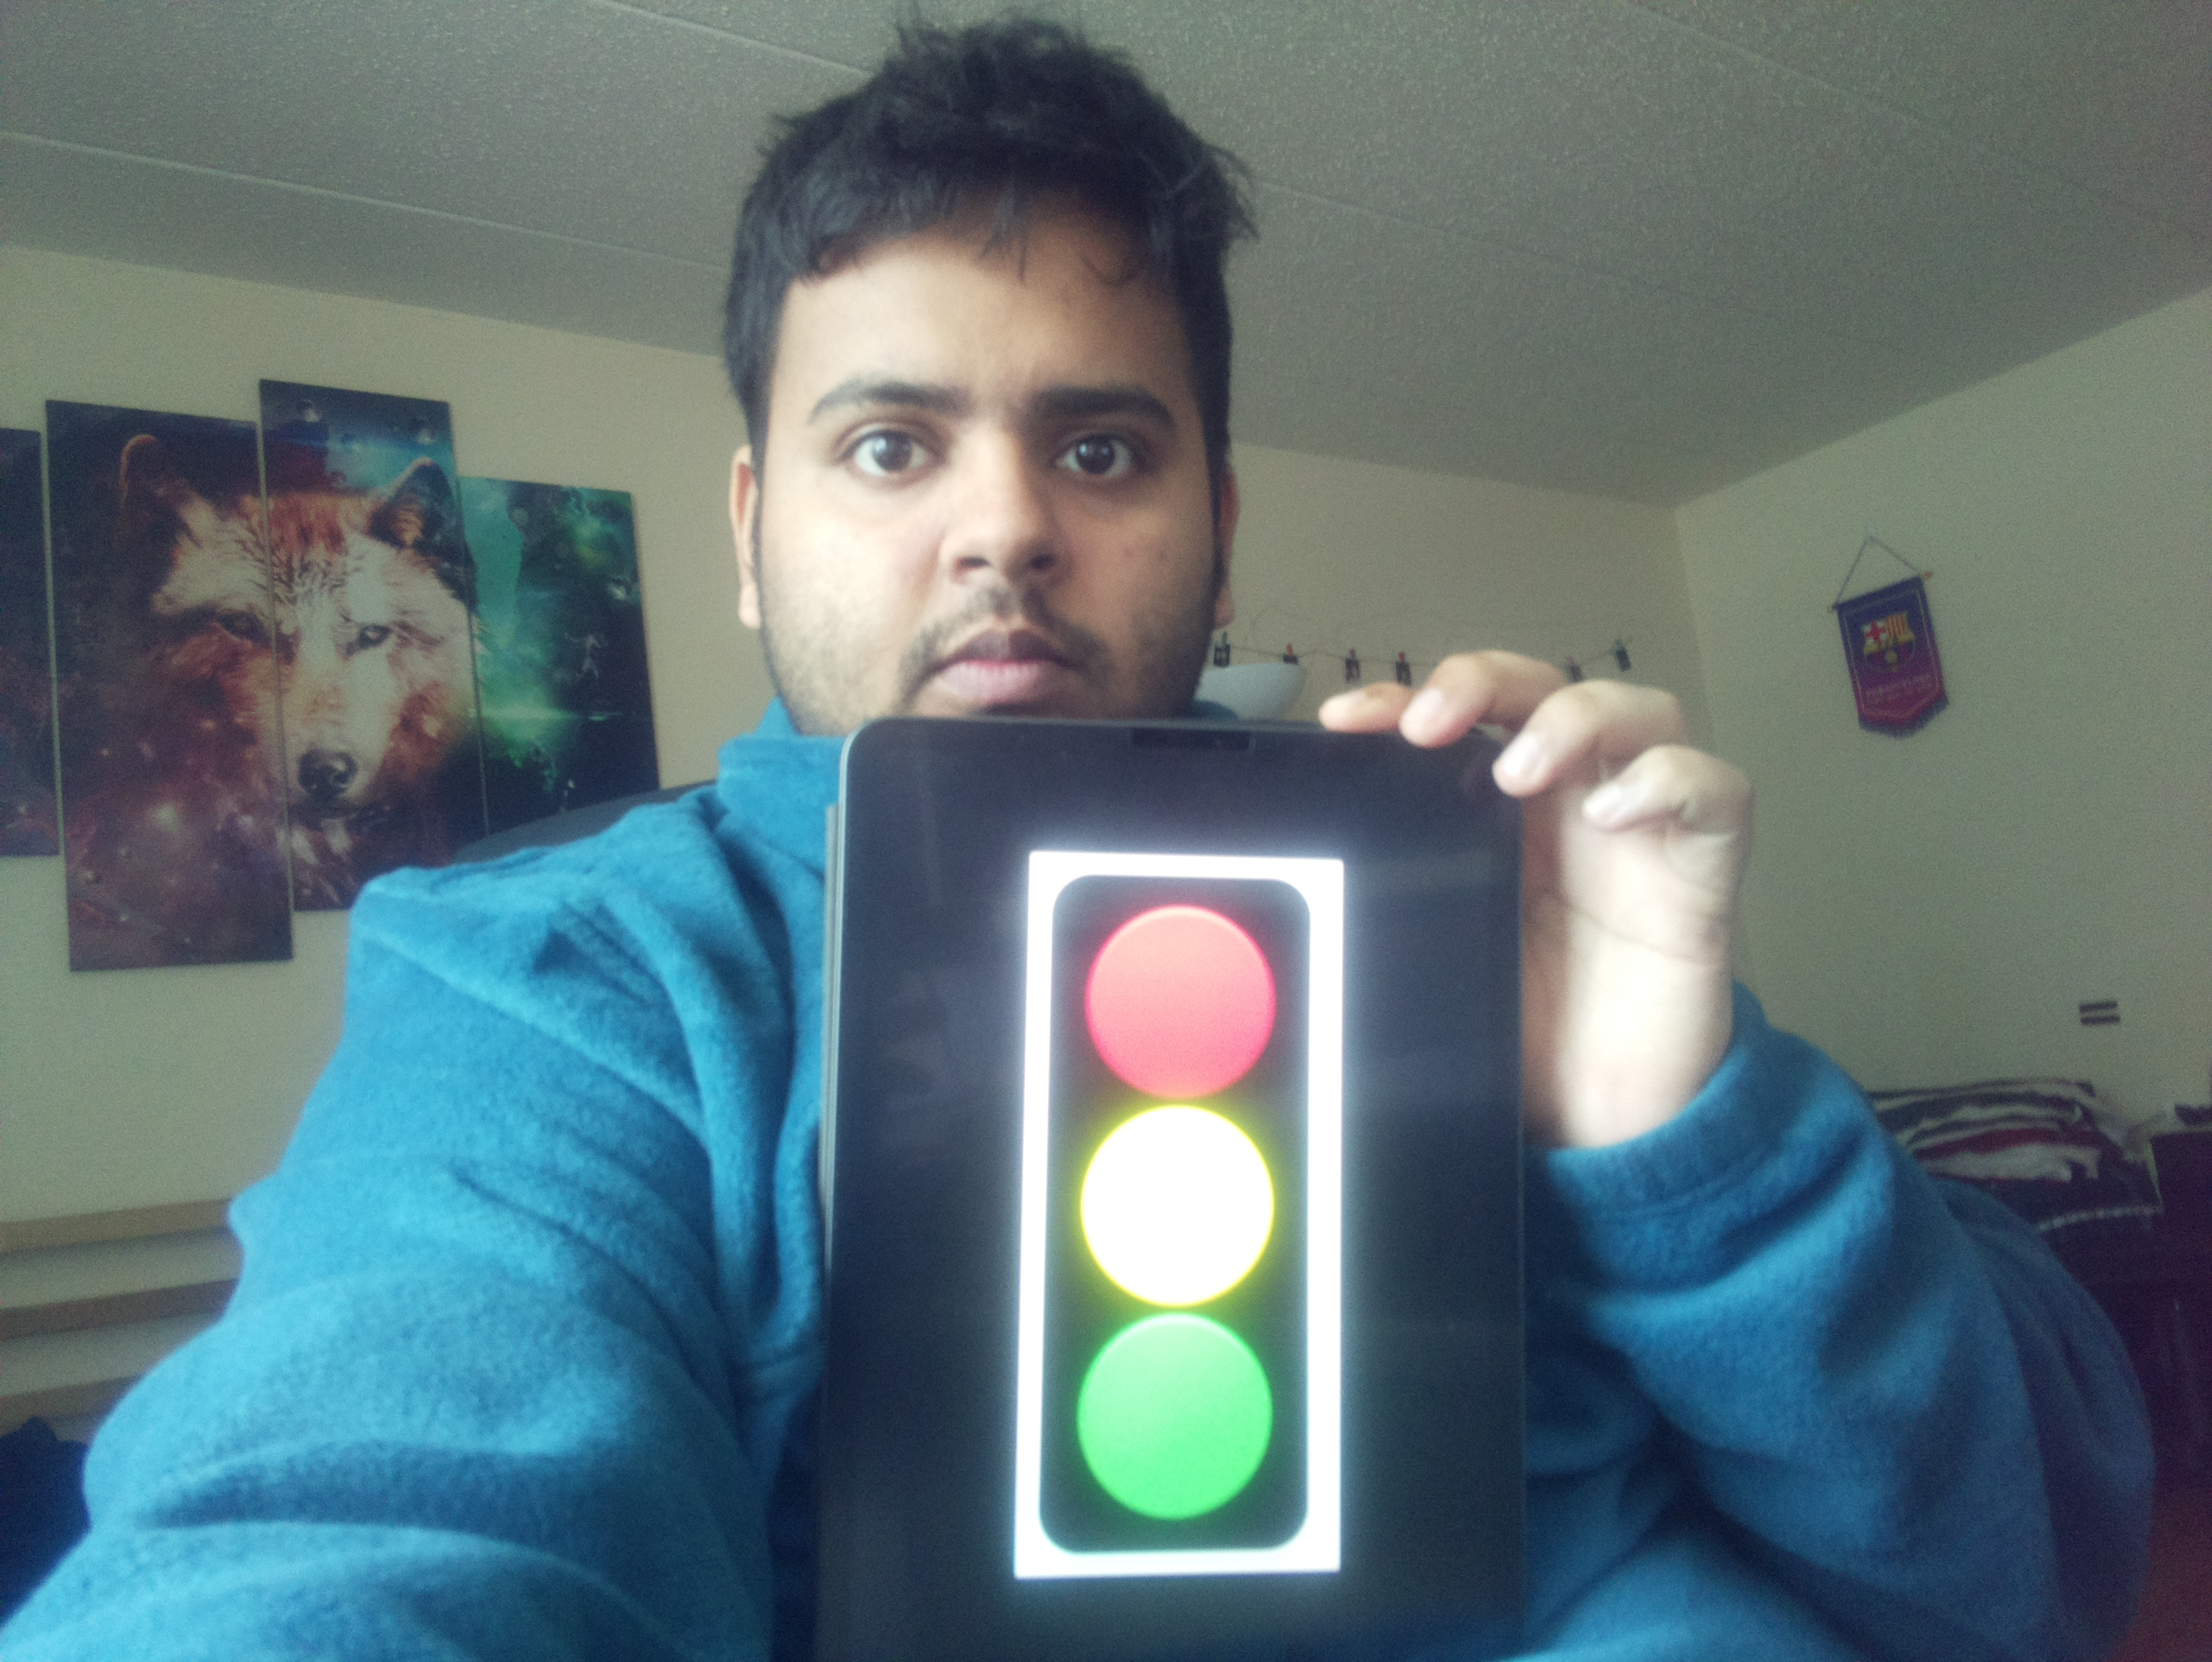

Now we do HSV masking to this image. Define upper and lower bounds to this HSV image using cv2.cvtColor() function. 

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
print("All packages imported properly")

All packages imported properly


In [2]:
image = cv2.imread("traffic.jpg")
image = imutils.resize(image,width=500)
cv2.imshow("traffic",image)
cv2.waitKey(0)
cv2.destroyAllWindows()
print(image.shape)

(375, 500, 3)


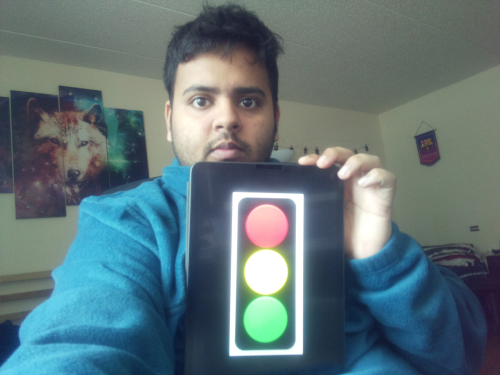

In [3]:
#Coverting to hsv image
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
cv2.imshow("hsv_image",hsv_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

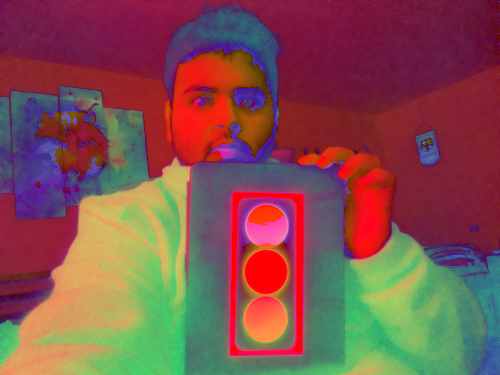

In [4]:
#Creating a HSV mask for ranges detected using our HSV image
minHSV = np.array([60,45,200])
maxHSV = np.array([80,145,255])
maskHSV = cv2.inRange(hsv_image,minHSV,maxHSV)
canvas = np.full(image.shape, fill_value=255,dtype="uint8")
resultHSV = cv2.bitwise_and(canvas, canvas, mask=maskHSV)
#Representing as a horizontal stack of images
Horizontal_stack = np.hstack([image,hsv_image,resultHSV])
cv2.imshow("Hor", Horizontal_stack)
cv2.waitKey(0)
cv2.destroyAllWindows()

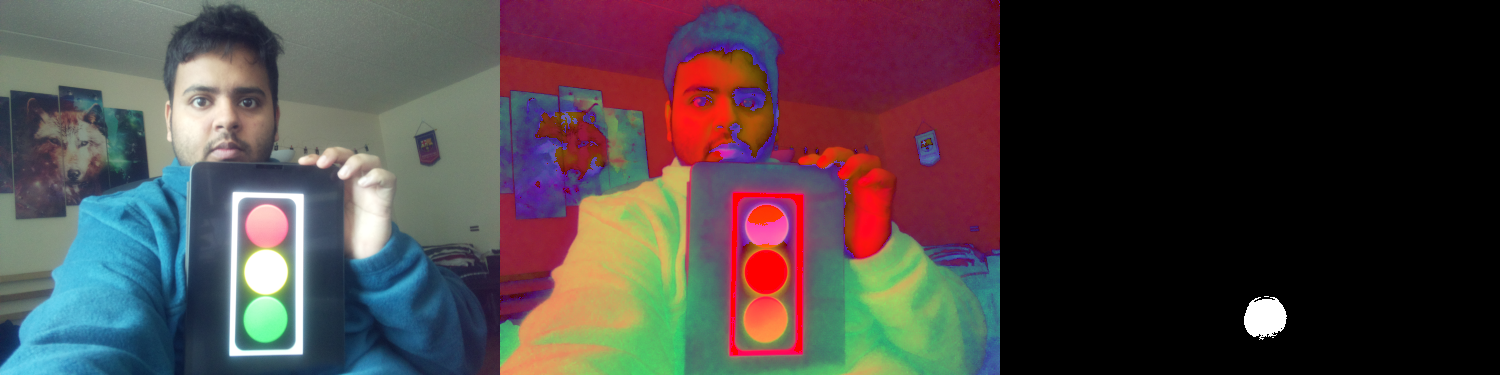

Step 2: Find contours and draw bounding circle

In [ ]:
#Using find contour function to detect contours, minimum enclosing circle function and the cv2.circle() function
contours = cv2.findContours(maskHSV.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
conts = imutils.grab_contours(contours)
if len(conts) > 0:   
    c = max(conts,key=cv2.contourArea)
    ((Cx,Cy),r) = cv2.minEnclosingCircle(c)
    M = cv2.moments(c)
    center = (int(M["m10"]/M["m00"]) , int(M["m01"]/M["m00"]))
    final = cv2.circle(image.copy(),(int(Cx),int(Cy)),int(r),(0,255,255),2)
    cv2.circle(final,center,3,(0,0,255),-1)

# show the frame to our screen
cv2.imshow("Frame", final)
cv2.waitKey(0)
cv2.destroyAllWindows()

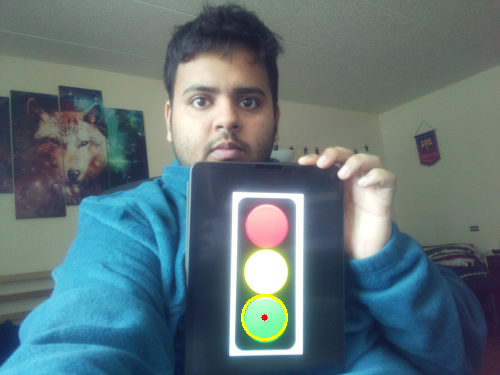

Step 3 and 4: Use info from step 1 and 2 and record and print in a video. <br>
Youtube link : https://youtu.be/veo4b-LWQBQ <br>

Step 5: Using the datetime module in RPi to check for delta measurememnts and plotting them <br>
The code attached here needs to be executed only on RPi and not on regular python

In [ ]:
## Do not run in Jupyter notebook

from picamera.array import PiRGBArray
from picamera import PiCamera
import time
import cv2
import numpy as np
import imutils
import datetime

#initialize the Raspberry Pi camera
camera=PiCamera()
camera.resolution=(640,480)
camera.framerate=30
rawCapture=PiRGBArray(camera,size=(640,480))
time.sleep(0.5)
fourcc=cv2.VideoWriter_fourcc(*'XVID')
out=cv2.VideoWriter('Sriku_video.avi',fourcc,10,(640,480))
#allow the camera to warmup
time.sleep(0.1)


file = open('hw3data.txt','a')
i=0

for frame in camera.capture_continuous(rawCapture,format="bgr",use_video_port=False):
    
    start = datetime.datetime.now()
    #grab the currennt frame
    image=frame.array
    
    image = cv2.flip(image,-1)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    minHSV = np.array([60,45,200])
    maxHSV = np.array([80,145,255])
    maskHSV = cv2.inRange(hsv_image,minHSV,maxHSV)
    canvas = np.full(image.shape, fill_value=255,dtype="uint8")
    resultHSV = cv2.bitwise_and(canvas, canvas, mask=maskHSV)
    contours = cv2.findContours(maskHSV.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    conts = imutils.grab_contours(contours)
    if len(conts) > 0:   
        c = max(conts,key=cv2.contourArea)
        ((Cx,Cy),r) = cv2.minEnclosingCircle(c)
        M = cv2.moments(c)
        center = (int(M["m10"]/M["m00"]) , int(M["m01"]/M["m00"]))
        final = cv2.circle(image.copy(),(int(Cx),int(Cy)),int(r),(0,255,255),2)
        cv2.circle(final,center,3,(0,0,255),-1)
    
  	#show the frame to our screen
    cv2.imshow("Frame",final)
    out.write(final)
    stop = datetime.datetime.now()
    now = (stop-start)
    outstring = str(now.total_seconds())+ '\n'
    print(now.total_seconds())
    file.write(outstring)
    i += 1
    print("i",i)
    
    
    key=cv2.waitKey(1) & 0xFF
    rawCapture.truncate(0)
    if key==ord("q"):
        break
cv2.destroyAllWindows()

Step 5 contd: Transfer hw3data.txt to laptop. Read the delta-time data and plot it. <br>

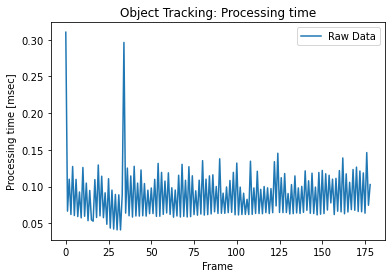

In [3]:
import numpy as np
import matplotlib.pyplot as plt
data = open('hw3data.txt','r').read()
count = 0
delta={}
for row in data.splitlines():
    (key,value)=(count,float(row.split()[0]))
    delta[key]=value  #storing information in this dictionary
    count+=1
# print('delta',delta)
plt.plot(delta.keys(), delta.values(),label='Raw Data')
plt.xlabel('Frame')
plt.ylabel('Processing time [msec]')
plt.title("Object Tracking: Processing time")
plt.legend(loc="upper right")
plt.show()

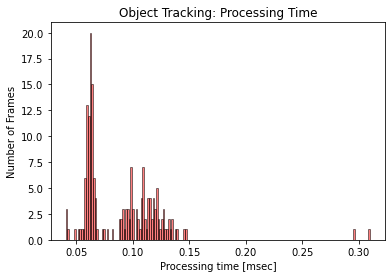

In [2]:
plt.figure(2)
plt.title('Object Tracking: Processing Time')
plt.xlabel('Processing time [msec]')
plt.ylabel('Number of Frames')
n, bins, patches = plt.hist(delta.values(), len(delta.values()), facecolor='r',edgecolor='k', alpha=0.5)
plt.show()

Clearly, we notice more or less the processing time remains uniform, however it is a bit jumpy due to the hardware limitations of Raspberry pi. Also, these jumps could probably be reduced by further finetuning our iterations. Code cleaning could possibly improve performance. Also, sudden movements in the camera further results in jumpy and more processing requirements. So, smoother performance can be attained if the picam mounting is done properly too. Also, a common problem with mcus and mpu's are their heating. Proper heatsinks could also improve performance.